# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

Get the dog and human dataset<br>
https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip<br>
http://vis-www.cs.umass.edu/lfw/lfw.tgz

Get the VGG16 bottleneck features<br>
https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


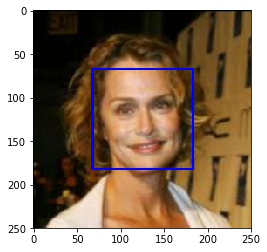

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
import cv2      
def face_detector(img_path):  
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_human = [face_detector(img)==True for img in human_files_short]
num_nohuman = [face_detector(img)==False for img in dog_files_short]

print('Correctly identified %d%% of humans!'%sum(num_human))
print('Did not get fooled by %d%% of dogs!'%sum(num_nohuman))

Correctly identified 98% of humans!
Did not get fooled by 89% of dogs!


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ I think this expectation is not completely unreasonable, but imposing any restriction / expectation on the user is generally not great and probably not appreciated by the average user. Instead of just focussing on the face, the algorithm could start with the cascaded approach and if the picture makes it through a certain number of detection levels but not all the way to the 'this is a human!' phase, it can be evaluated differently. A next step could be to check for a human body shape.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

num_dogs_humans = [dog_detector(img)==False for img in human_files_short]
num_dogs_dogs = [dog_detector(img)==True for img in dog_files_short]

print('Correctly identified %d%% of dogs!'%sum(num_dogs_dogs))
print('Did not get fooled by %d%% of humans!'%sum(num_dogs_humans))

Correctly identified 100% of dogs!
Did not get fooled by 99% of humans!


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:15<00:00, 54.55it/s]


In [10]:
# function for plotting the loss and accuracy history
import matplotlib.pyplot as plt                        
%matplotlib inline  

def plot_hist(history):
    # summarize history for accuracy
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I started with an architecture similar to the one in the example: 3 convolution layers (16, 32, 64 filters with a size of (2,2) and valid padding [Test A]) each followed by a (2,2) max pooling layer, followed by global average pooling and the output layer. This seems like a good starting architecture which in similar forms performed well in image classification tasks. Since the images ar fairly larges (224x224), as a first step I tested different filter sizes: (3,3)[Test B] and (11,11)[Test C] (with same padding) to see if larger filters can manage to capture the shapes in a better way. A filter size of (11,11) gave the best results so I decided to modify this architecture for further testing. 
I reduced the number of convolutional layers to two (16, 32)[Test D] and incresed it to four (16, 32, 64, 128)[Test E] to see if 3 layers is the right number to capture a good level of detail. I also added dropout before the global pooling [Test F] and after each max pooling layer [Test G] to reduce any overfitting, even though with the short training of 10 epochs this shouldn't be big issue so far. I tested adding additional fully connected layers after the convolutional layers (one layer with 512 nodes [Test H], and two layers with 512 and 256 nodes [Test I]) to see if this is beneficial to further classify the abstract features output by the convolutional part of the network. Finally I tried to double every convolutional layers and add max pooling layers after every second one (16,16,pooling , 32,32,pooling , 64,64,pooling) [Test J] and I tested to reverse the order of the convolutional layers (64, 32, 16)[Test K]. These tests were mainly shots in the dark to see if very different architectures could yield surprising results - they did not. The following table shows the accuracy on the test set using the best set of weights after 10 epochs of training.


| Test | Architecture | Test accuracy [%] | 
| --- | ------------- |:-----------------:| 
|  A  | Base test     | 4.6 | 
|  B  | A with filter size 3 | 5.8 |
|  C  | A with filter size 11 | 9.4 |
|  D  | C with 2 layers | 4.7 |
|  E  | C with 4 | 9.4 |
|  F  | C with one dropout | 10.4 |
|  G  | C with multiple dropout | 4.3 |
|  H  | C with one dense | 9.2 |
|  I  | C with two dense | 3.2 |
|  J  | C with double conv2d | 1.1 |
|  K  | C with reverse conv2d | 1.1 |

A large filter size and one dropout layer before the global average pooling layer gave the best result.  A lot of the architectures showed a behaviour of the loss function that suggests they would benefit from further training. Due to computational restrictions I decided to focus on test C which gave the best result after 10 epochs. I trained it for another 10 epochs (with early stopping) and since the loss behaviour still showed promise, for another 3 epochs before the early stopping interrupted the training. The final test accuracy is 17.2%.


In [34]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
# Convolutional layers
model.add(Conv2D(16, (11,11), padding='valid', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (11,11), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (11,11), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 214, 214, 16)      5824      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 107, 107, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 97, 97, 32)        61984     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 38, 38, 64)        247872    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 19, 64)        0         
__________

### Compile the Model

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Train on 6680 samples, validate on 835 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 4.87813, saving model to saved_models/weights6.best.from_scratch.hdf5
29s - loss: 4.9197 - acc: 0.0078 - val_loss: 4.8781 - val_acc: 0.0096
Epoch 2/10
Epoch 00001: val_loss improved from 4.87813 to 4.84147, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 4.8832 - acc: 0.0103 - val_loss: 4.8415 - val_acc: 0.0108
Epoch 3/10
Epoch 00002: val_loss improved from 4.84147 to 4.82711, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 4.8616 - acc: 0.0151 - val_loss: 4.8271 - val_acc: 0.0192
Epoch 4/10
Epoch 00003: val_loss improved from 4.82711 to 4.69024, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 4.7853 - acc: 0.0226 - val_loss: 4.6902 - val_acc: 0.0287
Epoch 5/10
Epoch 00004: val_loss improved from 4.69024 to 4.64248, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 4.6439 - acc: 0.0322 - va

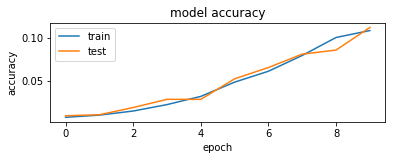

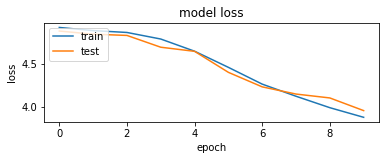

In [37]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

plot_hist(history)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 4.16294, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 3.7638 - acc: 0.1286 - val_loss: 4.1629 - val_acc: 0.0850
Epoch 2/10
Epoch 00001: val_loss improved from 4.16294 to 3.86227, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 3.6635 - acc: 0.1436 - val_loss: 3.8623 - val_acc: 0.1234
Epoch 3/10
Epoch 00002: val_loss did not improve
29s - loss: 3.5761 - acc: 0.1608 - val_loss: 4.0791 - val_acc: 0.1102
Epoch 4/10
Epoch 00003: val_loss improved from 3.86227 to 3.78836, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 3.4703 - acc: 0.1835 - val_loss: 3.7884 - val_acc: 0.1449
Epoch 5/10
Epoch 00004: val_loss did not improve
28s - loss: 3.3739 - acc: 0.2016 - val_loss: 3.8422 - val_acc: 0.1413
Epoch 6/10
Epoch 00005: val_loss improved from 3.78836 to 3.77456, saving model to saved_models/weights6.best.from_scratch.hd

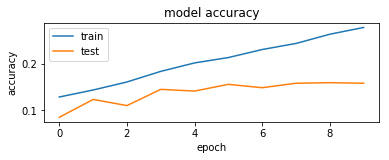

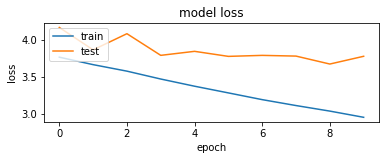

In [50]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

from keras.callbacks import ModelCheckpoint, EarlyStopping

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=4)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopper], verbose=2)

plot_hist(history)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 3.78994, saving model to saved_models/weights6.best.from_scratch.hdf5
29s - loss: 2.9463 - acc: 0.2732 - val_loss: 3.7899 - val_acc: 0.1760
Epoch 2/50
Epoch 00001: val_loss improved from 3.78994 to 3.68440, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 2.8725 - acc: 0.3000 - val_loss: 3.6844 - val_acc: 0.1737
Epoch 3/50
Epoch 00002: val_loss improved from 3.68440 to 3.60101, saving model to saved_models/weights6.best.from_scratch.hdf5
28s - loss: 2.8016 - acc: 0.3073 - val_loss: 3.6010 - val_acc: 0.1832
Epoch 4/50
Epoch 00003: val_loss did not improve
28s - loss: 2.7174 - acc: 0.3204 - val_loss: 3.7351 - val_acc: 0.1892
Epoch 5/50
Epoch 00004: val_loss did not improve
28s - loss: 2.6545 - acc: 0.3382 - val_loss: 3.6525 - val_acc: 0.1772
Epoch 6/50
Epoch 00005: val_loss did not improve
29s - loss: 2.5926 - acc: 0.3475 - val_loss: 3.6515 - val_acc: 0.1737
Epoch 

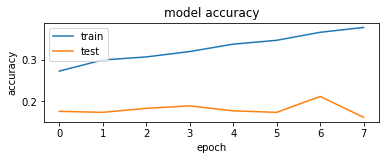

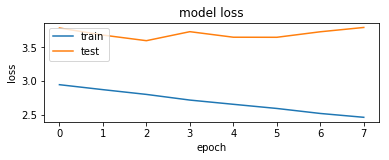

In [52]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

from keras.callbacks import ModelCheckpoint, EarlyStopping

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=4)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopper], verbose=2)

plot_hist(history)

### Load the Model with the Best Validation Loss

In [36]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [37]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 17.2249%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [248]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [249]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [250]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [41]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s - loss: 11.8877 - acc: 0.1284 - val_loss: 10.2224 - val_acc: 0.2192
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.4279 - acc: 0.3009 - val_loss: 9.5352 - val_acc: 0.2754
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.7569 - acc: 0.3701 - val_loss: 9.1344 - val_acc: 0.3293
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.3997 - acc: 0.4171 - val_loss: 8.8860 - val_acc: 0.3605
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.1755 - acc: 0.4446 - val_loss: 8.8701 - val_acc: 0.3497
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 8.0561 - acc: 0.4615 - val_loss: 8.7365 - val_acc: 0.3689
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 7.9212 - acc: 0.4753 - val_loss: 8.6196 - val_acc: 0.3856
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 7.7121 - 

### Load the Model with the Best Validation Loss

In [251]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [43]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.6077%


### Predict Dog Breed with the Model

In [20]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [291]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I started by comparing the baseline accuracies of the different bottleneck models using just a global average pooling and an output layer. At this point the Xception and Inception model had some problems and I decided to work with the Resnet50 model which gave the highest baseline accuracy.<br>
I experimented with adding a fully connected layer with different number of nodes. The accuracy went down but it also looked like the model was overfitting. I decided to add dropout layers and after experimenting with different combinations of before and after the fully connected layer, I decided to use the layout seen below. It contains a fully connected layer using 1024 nodes (this seemed to be high enough to capture all the features since higher number of nodes didn't seem to improve the results), a weak regularisation in form of a 10% dropout layer before and a stronger regularisation in form of a 70% dropout layer after. The global average pooling layer already performs a regularisation so the first dropout layer is fairly weak. My tests showed that the model is benefitting from a very strong second dropout layer since the model was prone to overfitting and lower dropout values decreased accuracy. The final accuracy of this model is 83.25% after about 30 epochs of training.

After the bottleneck features for the Inception and Xception models were fixed I tested them as well. Surprisingly the Xception model performed Xceptionally well. The baseline model using just the global average pooling and output layers already outperformed my Resnet50 approach. I tried adding a number of different fully connected layers but even with different regularisation strategies, the final accuracy was always lower or equal to the baseline and prone to overfitting. Finally I decided to add just a dropout layer with 20% between the global average pooling and the output layer. This very simple model gave an accuracy of 86.12% after just 11 epochs of training and so far I didn't manage to improve upon this.<br>
This leads me to believe that the bottleneck features coming out of the Xception model are already very well suited for the dog breed classification task and adding a simple fully connected model on top of it hurts the results more than it helps them. I think adding a deeper more complex additional layout (more than 3 fully connected layers with good regularisation strategies) could increase these results by specialising entirely on mapping the bottleneck features to the dog breeds but would involve a lot of training and slower computation of results in the end. <br>
I also tested different batch sizes and optimizers, adagrad with a batch size of 20 gave the best results closely followed by adam with a batch size of 100.



In [338]:
### TODO: Define your architecture.
resnet_model = Sequential()
resnet_model.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))

resnet_model.add(Dropout(0.1))
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dropout(0.7))
resnet_model.add(Dense(133, activation='softmax'))

resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_99  (None, 2048)              0         
_________________________________________________________________
dropout_182 (Dropout)        (None, 2048)              0         
_________________________________________________________________
dense_228 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_183 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_229 (Dense)            (None, 133)               136325    
Total params: 2,234,501.0
Trainable params: 2,234,501.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [339]:
### TODO: Compile the model.
resnet_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 2.68663, saving model to saved_models/weights.best.resnet.hdf5
17s - loss: 10.0126 - acc: 0.1069 - val_loss: 2.6866 - val_acc: 0.4395
Epoch 2/100
Epoch 00001: val_loss improved from 2.68663 to 1.29763, saving model to saved_models/weights.best.resnet.hdf5
13s - loss: 2.5036 - acc: 0.4007 - val_loss: 1.2976 - val_acc: 0.6766
Epoch 3/100
Epoch 00002: val_loss improved from 1.29763 to 0.90516, saving model to saved_models/weights.best.resnet.hdf5
16s - loss: 1.6462 - acc: 0.5590 - val_loss: 0.9052 - val_acc: 0.7569
Epoch 4/100
Epoch 00003: val_loss improved from 0.90516 to 0.77795, saving model to saved_models/weights.best.resnet.hdf5
17s - loss: 1.3141 - acc: 0.6296 - val_loss: 0.7779 - val_acc: 0.7713
Epoch 5/100
Epoch 00004: val_loss improved from 0.77795 to 0.71447, saving model to saved_models/weights.best.resnet.hdf5
16s - loss: 1.0920 - acc: 0.6892 - val_loss: 0.7145 - val_acc: 0.7

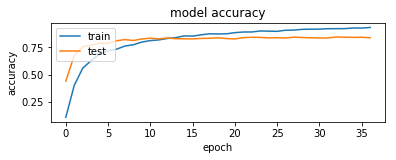

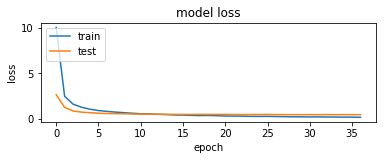

In [340]:
### TODO: Train the model.
from keras.callbacks import EarlyStopping
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=4)

history = resnet_model.fit(train_resnet, train_targets, 
          validation_data=(valid_resnet, valid_targets),
          epochs=100, batch_size=20, callbacks=[checkpointer, early_stopper], verbose=2)
plot_hist(history)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [341]:
### TODO: Load the model weights with the best validation loss.
resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [342]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.2536%


## Test the Xception model

In [12]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_xception = bottleneck_features['train']
valid_xception = bottleneck_features['valid']
test_xception = bottleneck_features['test']

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### TODO: Define your architecture.
xception_model = Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))

xception_model.add(Dropout(0.2))
xception_model.add(Dense(133, activation='softmax'))

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [14]:
### TODO: Compile the model.
xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.54486, saving model to saved_models/weights.best.xception.hdf5
20s - loss: 1.1841 - acc: 0.7175 - val_loss: 0.5449 - val_acc: 0.8335
Epoch 2/100
Epoch 00001: val_loss improved from 0.54486 to 0.49784, saving model to saved_models/weights.best.xception.hdf5
9s - loss: 0.3766 - acc: 0.8867 - val_loss: 0.4978 - val_acc: 0.8467
Epoch 3/100
Epoch 00002: val_loss improved from 0.49784 to 0.47879, saving model to saved_models/weights.best.xception.hdf5
7s - loss: 0.2509 - acc: 0.9289 - val_loss: 0.4788 - val_acc: 0.8527
Epoch 4/100
Epoch 00003: val_loss improved from 0.47879 to 0.46676, saving model to saved_models/weights.best.xception.hdf5
8s - loss: 0.1823 - acc: 0.9506 - val_loss: 0.4668 - val_acc: 0.8395
Epoch 5/100
Epoch 00004: val_loss did not improve
7s - loss: 0.1365 - acc: 0.9693 - val_loss: 0.4942 - val_acc: 0.8371
Epoch 6/100
Epoch 00005: val_loss did not improve
6s - loss: 0.10

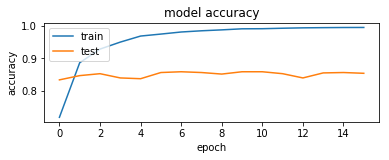

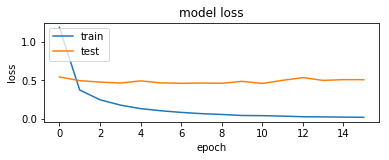

In [93]:
### TODO: Train the model.
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=4)

history = xception_model.fit(train_xception, train_targets, 
          validation_data=(valid_xception, valid_targets),
          epochs=100, batch_size=20, callbacks=[checkpointer, early_stopper], verbose=2)
plot_hist(history)

In [26]:
### TODO: Load the model weights with the best validation loss.
xception_model.load_weights('saved_models/weights.best.xception.hdf5')

### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.1244%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [15]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import*

def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    prediction = xception_model.predict(bottleneck_feature)
    breeds = [dog_names[i] for i in mixed_breed(prediction)]
    return breeds

In [16]:
# Check if the dog is a mixed breed
# return two highest breeds if highest value is < 1.5 second highest
def mixed_breed(prediction):
    highest = np.flip(prediction.argsort()[0][-2:],0)
    if prediction[0][highest[0]] > prediction[0][highest[1]]*1.5:
        return [highest[0]]
    else:        
        return highest

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [140]:
xception_model.save('xception_dog_breed.h5')

In [17]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

# Function to check if human and/or dog is present in the image
# returns dog,human with each either True or False
def check_human_dog(img_path):
    dog = dog_detector(img_path)
    human = face_detector(img_path)
    return dog, human

In [18]:
# Reads and displays a picture
import cv2                
import matplotlib.pyplot as plt 
%matplotlib inline      

def show_picture(img_path):
    img = cv2.imread(img_path)
    plt.axis("off")
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(cv_rgb)
    plt.show()

In [49]:
# Saves the picture from the provided URL for future use
from skimage import io
def convert_url(url):
    img = io.imread(url)
    img_path = './images/input1.jpg'
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    return img_path

In [21]:
# Looks on google image search for a picture of the dog breed and displays it

def show_google_picture(breed):
    google_search(breed)
    for i in range(5):
        try:
            show_picture('images/gsearch_'+str(i+1)+'.jpg')
            break
        except:
            continue

In [67]:
# Checks if there is a human or dog in the picture and finds the closest matching breed
# -*- coding: UTF-8 -*-

def check_breed(img_path):
    isdog, ishuman = check_human_dog(img_path)
    
    # no dog or human detected
    if not isdog and not ishuman: 
        show_picture(img_path)
        raise Exception("I can't see a dog or a human, try another picture!")

    # dog detected
    if isdog:
        show_picture(img_path)
        breed = Xception_predict_breed(img_path)
        if len(breed)>1:
            print("I'm a mix between %s and %s! Woof!"%(breed[0],breed[1]))
        else:  
            print("I'm a %s! Woof!"%breed[0])
            
    # human detected
    elif ishuman:
        show_picture(img_path)
        breed = Xception_predict_breed(img_path)
        print("I'm no dog but I looke like a %s! \U0001f604"%breed[0])
        show_google_picture(breed[0])

In [59]:
# Search for picture of dog on google images and display it
# This bit is a modified version found on https://github.com/hardikvasa/google-images-download
import time

#Downloading entire Web Document (Raw Page Content)
def download_page(url):
    import urllib.request    #urllib library for Extracting web pages
    try:
        headers = {}
        headers['User-Agent'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"
        req = urllib.request.Request(url, headers = headers)
        resp = urllib.request.urlopen(req)
        respData = str(resp.read())
        return respData
    except Exception as e:
        print(str(e))

#Finding 'Next Image' from the given raw page
def _images_get_next_item(s):
    start_line = s.find('rg_di')
    if start_line == -1:    #If no links are found then give an error!
        end_quote = 0
        link = "no_links"
        return link, end_quote
    else:
        start_line = s.find('"class="rg_meta"')
        start_content = s.find('"ou"',start_line+1)
        end_content = s.find(',"ow"',start_content+1)
        content_raw = str(s[start_content+6:end_content-1])
        return content_raw, end_content

#Getting all links with the help of '_images_get_next_image'
def _images_get_all_items(page):
    items = []
    j=0
    while j<5:
        item, end_content = _images_get_next_item(page)
        if item == "no_links":
            break
        else:
            items.append(item)      #Append all the links in the list named 'Links'
            time.sleep(0.1)        #Timer could be used to slow down the request for image downloads
            page = page[end_content:]
        j+=1
    return items

def google_search(search_keyword):
    #Download Image Links
    search = search_keyword.replace(' ','%20')
    url = 'https://www.google.co.uk/search?q=' + search + '%20dog%20high%20resolution&site=webhp&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiU66C-ndzUAhWHtBQKHcWSDYkQ_AUIBigB'
    raw_html = (download_page(url))
    items = _images_get_all_items(raw_html)

    k=0
    errorCount=0
    while(k<len(items)):
        from urllib.request import Request, urlopen    #urllib library for Extracting web pages
        from urllib.error import URLError, HTTPError

        try:
            req = Request(items[k], headers={"User-Agent": "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"})
            response = urlopen(req)
            output_file = open("images/gsearch_"+str(k+1)+".jpg",'wb')
            data = response.read()
            output_file.write(data)
            response.close();
            k=k+1;

        except IOError:   #If there is any IOError
            errorCount+=1
            k=k+1;
        except HTTPError as e:  #If there is any HTTPError
            errorCount+=1
            k=k+1;
        except URLError as e:
            errorCount+=1
            k=k+1;

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output seems to be quite accurate. Most dog breeds are correctly classified (including mixed breeds), it often does not get fooled by cats or other animals (depending on the type of photo), and the breeds suggested for humans tend to resemble the person.
As possible improvements / extensions following things come to mind: the algorithm could identify different people and dogs on a picture and provide predictions for all of them. Instead of just analysing the picture to see if a dog is present, the algorithm could also crop the picture to the area that contains the most significant features of the dog (exclude everything apart from the body + head, or possibly even just keep the head) before checking for the breed. The algorithm could offer a review button where people can like or dislike the chosen breed and use the results to update the model to learn and improve over time.

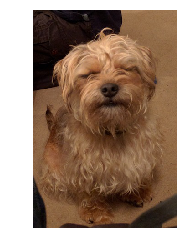

I'm a Norfolk_terrier! Woof!


In [27]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

img_path = 'images/dog1.jpg'

try:
    check_breed(img_path)
except Exception as inst:
    print(inst)

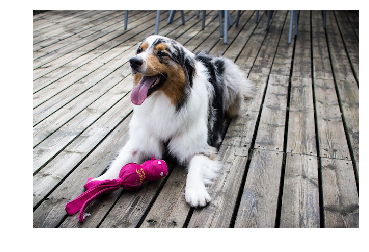

I'm a Australian_shepherd! Woof!


In [28]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

img_path = 'images/dog8.jpg'

try:
    check_breed(img_path)
except Exception as inst:
    print(inst)

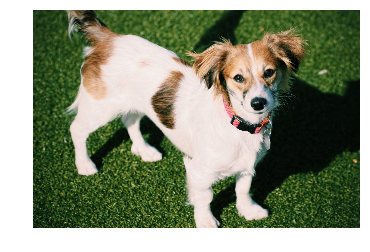

I'm a mix between Parson_russell_terrier and Norwegian_lundehund! Woof!


In [51]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

url = 'http://ghk.h-cdn.co/assets/16/13/980x653/gallery-1459439233-fleur-yvonne-young.jpg'

try:
    img_path = convert_url(url)
    check_breed(img_path)
except Exception as inst:
    print(inst)

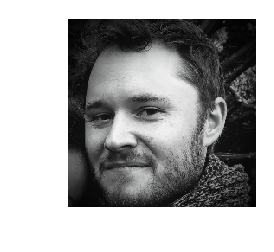

I'm no dog but I looke like a Cocker_spaniel! 😄


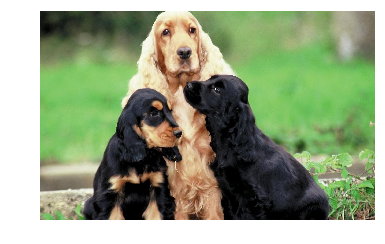

In [60]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

img_path = 'images/me.png'

try:
    check_breed(img_path)
except Exception as inst:
    print(inst)

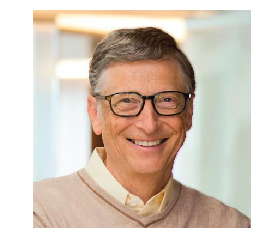

I'm no dog but I looke like a Petit_basset_griffon_vendeen! 😄


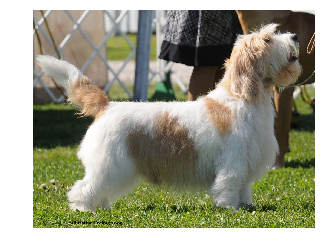

In [61]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

url='https://pbs.twimg.com/profile_images/558109954561679360/j1f9DiJi.jpeg'

try:
    img_path = convert_url(url)
    check_breed(img_path)
except Exception as inst:
    print(inst)


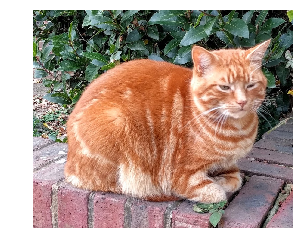

I can't see a dog or a human, try another picture!


In [69]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

img_path = 'images/cat.jpg'

try:
    check_breed(img_path)
except Exception as inst:
    print(inst)